In [1]:
import pickle
import pandas as pd
import numpy as np

In [2]:
six_bins_fp = "results/run_six_bins/robustness_experiment.pkl"
# eight_bins_fp = 'results/run_eight_bins/robustness_experiment.pkl'
with open(six_bins_fp, "rb") as f:
    six_bins_data = pickle.load(f)

# with open(eight_bins_fp, 'rb') as f:
#     eight_bins_data = pickle.load(f)

# now need to get the data into a sensible format


In [13]:
df_data = []
# the data contains runs for a seed - each seed has 20 experiments with different
# lengths - and at each length there are 250 evaluations - so need to unnest and
# extract the relevant info.
for exp in six_bins_data:
    seed = exp['seed']
    results = exp['results']
    for run in results:
        length = run['length']
        for i in range(250):
            returns_conf = run['returns_conf'][i]
            returns_noconf = run['returns_noconf'][i]
            run_info = {
                'seed': seed,
                'length': length,
                'returns_conf': returns_conf,
                'returns_noconf': returns_noconf
            }
            df_data.append(run_info)

In [144]:
df_raw = pd.DataFrame(df_data)
df_grp = df_raw.groupby(['seed', 'length']).mean().reset_index()
# if training went properly this should be 500
# let's see what happens if we filter these seeds out - since the training kind of blew up
default_runs = df_grp[df_grp['length'] == 0.5]
bad_seeds = default_runs.loc[default_runs['returns_noconf'] < 490, 'seed'].to_list()

df_filtered = df_grp[~df_grp['seed'].isin(bad_seeds)]

In [145]:
# # median plot looks pretty tasty
# medians = df_filtered.groupby('length')[['returns_conf', 'returns_noconf']].median()
# ax = medians.plot(marker='o')
# ax.set_ylabel('Median Episodic Return')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_ylim(0, 550)
# ax.set_xlim(0.0, 2.1)
# ax.grid(alpha=0.3, linestyle='--')
# ax.axvline(0.5, linestyle='--', color='k', zorder=0, alpha=0.5)
# ax.legend(frameon=False);

In [146]:
returns_conf_clean = df_filtered.pivot(index='seed', columns='length', values='returns_conf').to_numpy()
returns_conf_clean = returns_conf_clean.reshape(-1, 1, 20)
returns_noconf_clean = df_filtered.pivot(index='seed', columns='length', values='returns_noconf').to_numpy()
returns_noconf_clean = returns_noconf_clean.reshape(-1, 1, 20)

In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

score_dict = {
    'No Calibration': returns_noconf_clean,
    'Train-time Calibration': returns_conf_clean,
}

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., length])
                               for length in range(scores.shape[-1])])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  score_dict, iqm, reps=50_000)


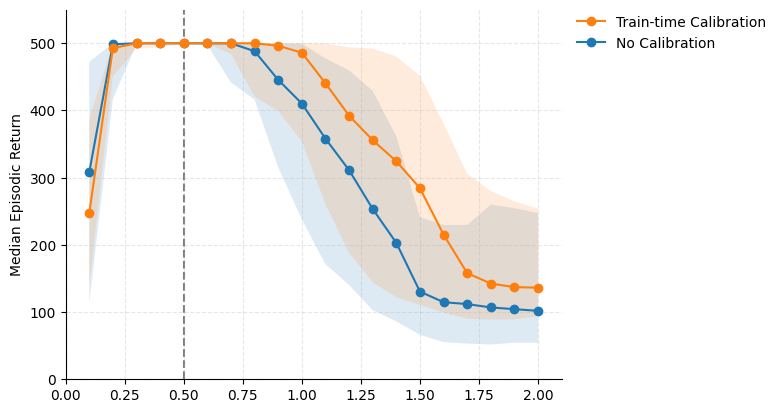

In [ ]:
import matplotlib.pyplot as plt

lengths = np.linspace(0.1, 2.0, 20)
for algo in aggregate_scores:
    iqms = aggregate_scores[algo]
    lower, upper = aggregate_score_cis[algo]
    plt.plot(lengths, iqms, marker="o", label=algo)
    plt.fill_between(lengths, lower, upper, alpha=0.15)

# plt.plot(aggregate_scores)
ax = plt.gca()
ax.set_ylabel("Episodic Return (IQM)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, 550)
ax.set_xlim(0.0, 2.1)
ax.grid(alpha=0.3, linestyle="--")
ax.axvline(0.5, linestyle="--", color="k", zorder=0, alpha=0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, reverse=True);

In [ ]:
# probability of improvement
procgen_algorithm_pairs = {.. , 'x,y': (score_x, score_y), ..}
average_probabilities, average_prob_cis = rly.get_interval_estimates(
  procgen_algorithm_pairs, metrics.probability_of_improvement, reps=2000)
plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)

array([113.59      , 417.182     , 499.12      , 500.        ,
       500.        , 497.15933333, 441.734     , 416.09      ,
       314.37933333, 240.10466667, 168.68333333, 135.43466667,
       103.05      ,  86.16835   ,  65.55016667,  54.90266667,
        53.20066667,  51.586     ,  54.13066667,  54.152     ])